In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv("Larger_Activities.csv")

#Clean Data First

#Date
data["Date"] = pd.to_datetime(data["Date"])
data = data[(data["Date"].dt.month >= 6) & (data["Date"].dt.month < 10)]

#Weekday and week columns
data["Weekday"] = data["Date"].dt.day_name()

data["Week_Start"] = data["Date"].dt.to_period("W-SUN").apply(lambda r: r.start_time)
data["Week"] = data["Week_Start"].rank(method="dense").astype(int)

#Dropping columns
data = data[["Date", "Week", "Weekday", "Distance", "Calories", "Time", "Avg HR", "Max HR", "Avg Pace", "Best Pace", "Total Ascent", "Total Descent", "Steps"]]
#Turning strings into numbers

data = data.copy()
cols = ["Distance", "Calories", "Steps", "Total Ascent", "Total Descent"]

for col in cols:
    data[col] = data[col].astype(str).str.replace(",","").replace("--", "0").astype(float)

#Time and Pace functions

def time_converter(str):
    h,m = str.split(":")
    h = int(h)
    m = int(m)
    total = (60*h) +m
    return total

def pace_converter(pace):
    m,s = pace.split(":")
    m = int(m)
    s = int(s)
    s = (s*(5/3))/100
    final_pace = m+s
    return round(final_pace,2)

data["Time"] = data["Time"].apply(time_converter)
data["Avg Pace"] = data["Avg Pace"].apply(pace_converter)
data["Best Pace"] = data["Best Pace"].apply(pace_converter)

#Change Distances due to some being meters
data.loc[data["Distance"] > 100, "Distance"] = round(data["Distance"] / 1609.34, 2)
#data.loc[rows_to_change, columns_to_change] = new_value

#Add months
data["Month"] = data["Date"].dt.month_name()
months_ordered = months_ordered = ["January", "February", "March", "April", "May", "June",
         "July", "August", "September", "October", "November", "December"]

data["Month"] = pd.Categorical(data["Month"], ordered=True, categories=months_ordered)

#Adding Zones
zone_bins = [0,120,145,160,175,200]
zone_labels = ["Zone 1", "Zone 2", "Zone 3", "Zone 4", "Zone 5"]
data["Zones"] = pd.cut(data["Avg HR"], bins=zone_bins, labels=zone_labels, right=False)

#Lastly drop columns
data = data[["Date", "Week", "Weekday", "Distance", "Calories", "Time", "Avg HR", "Max HR", "Avg Pace", "Best Pace","Zones", "Total Ascent", "Total Descent", "Steps"]]
data.head()





,Date,Week,Weekday,Distance,Calories,Time,Avg HR,Max HR,Avg Pace,Best Pace,Zones,Total Ascent,Total Descent,Steps
5,2025-09-30 20:07:27,19,Tuesday,10.01,1243.0,77,165,190,7.67,5.60,Zone 4,62.0,72.0,12674.0
6,2025-09-28 23:07:55,18,Sunday,8.56,1035.0,75,141,150,8.67,5.75,Zone 2,26.0,46.0,11904.0
7,2025-09-27 10:21:20,18,Saturday,16.01,1944.0,131,153,177,8.15,6.60,Zone 3,230.0,203.0,21386.0
8,2025-09-26 09:25:42,18,Friday,5.00,539.0,53,129,140,10.47,9.03,Zone 2,0.0,0.0,8338.0
9,2025-09-25 11:48:47,18,Thursday,8.01,887.0,62,144,178,7.72,6.80,Zone 2,98.0,79.0,10314.0


In [16]:
#We see we have some big outliers so lets change that
hr_pace = data[["Avg Pace","Avg HR"]]
hr_pace = hr_pace[(hr_pace["Avg Pace"] < 20) & (hr_pace["Avg HR"] > 110)]
hr_pace

,Avg Pace,Avg HR
5,7.67,165
6,8.67,141
7,8.15,153
8,10.47,129
9,7.72,144
...,...,...
134,10.73,134
135,9.13,138
136,5.47,155
137,9.52,146


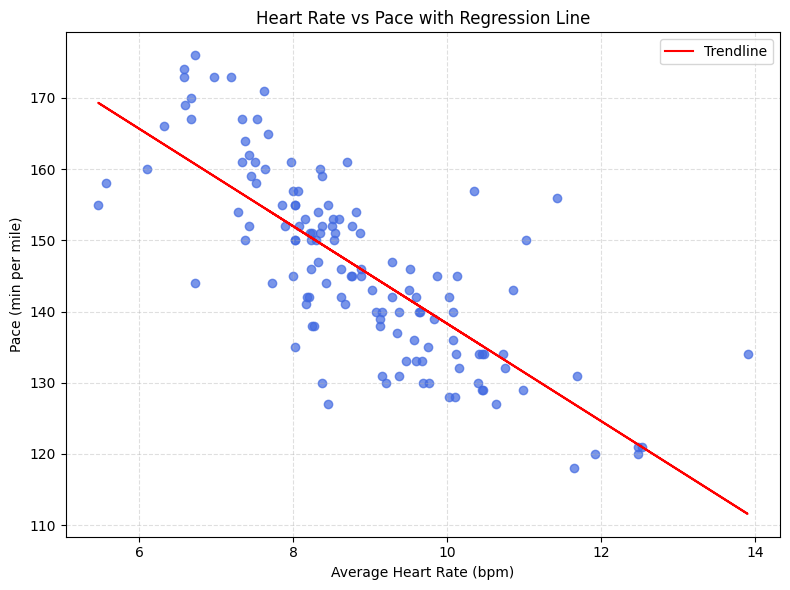

In [19]:
# Creating the graph
plt.figure(figsize=(8,6))
plt.scatter(hr_pace["Avg Pace"], hr_pace["Avg HR"], color="royalblue", alpha = 0.7)
plt.grid(True, linestyle="--", alpha=0.4)


#Adding the linear regression line
z = np.polyfit(hr_pace["Avg Pace"], hr_pace["Avg HR"], 1)
#z = np.polyfit(x, y, 1) fits a polynomial of degree 1 (a straight line) return coeffecients [m,b]
p = np.poly1d(z)
#Converts that [m, b] array into a callable function.
# You can now compute predicted y-values: p(150) gives pace at HR=150.
plt.plot(hr_pace["Avg Pace"], p(hr_pace["Avg Pace"]), color="red", label="Trendline")

plt.title("Heart Rate vs Pace with Regression Line")
plt.xlabel("Average Heart Rate (bpm)")
plt.ylabel("Pace (min per mile)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [21]:
#Quick show of correlation
pace_hr_corr = hr_pace["Avg Pace"].corr(hr_pace["Avg HR"])
pace_hr_corr.round(2)

np.float64(-0.77)

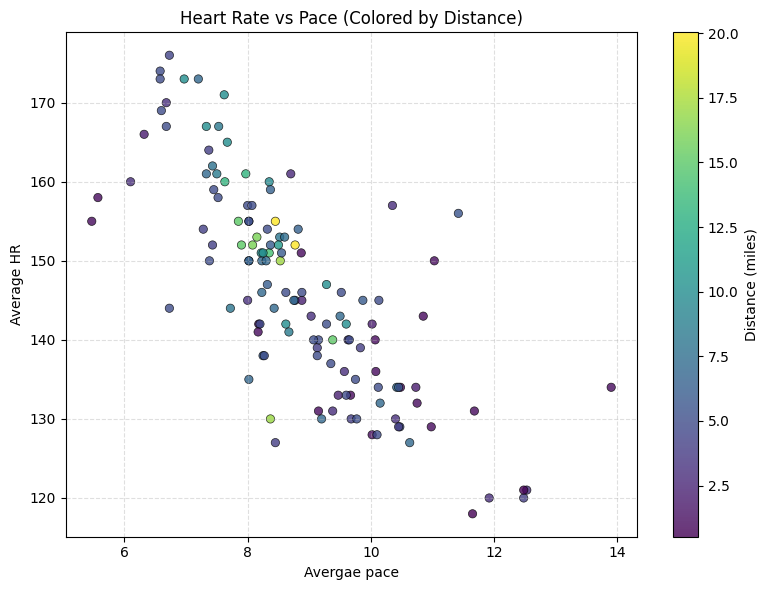

In [25]:
#Goal How does distance affect the relationship between average pace and average heart rate?

#Step 1 Filter the data

reg_data = data[(data["Avg HR"] > 110) & data["Avg HR"] < 190]
reg_data = reg_data[(reg_data["Distance"] > 1) & reg_data["Distance"] < 30]
reg_data = reg_data[(reg_data["Avg Pace"] < 20)]

#Make the scatter

plt.figure(figsize=(8,6))

sc = plt.scatter(reg_data["Avg Pace"], reg_data["Avg HR"], c=reg_data["Distance"], cmap="viridis", alpha=0.8, edgecolors="black",linewidth=0.5)

plt.colorbar(sc, label="Distance (miles)")
plt.title("Heart Rate vs Pace (Colored by Distance)")
plt.xlabel("Avergae pace")
plt.ylabel("Average HR")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


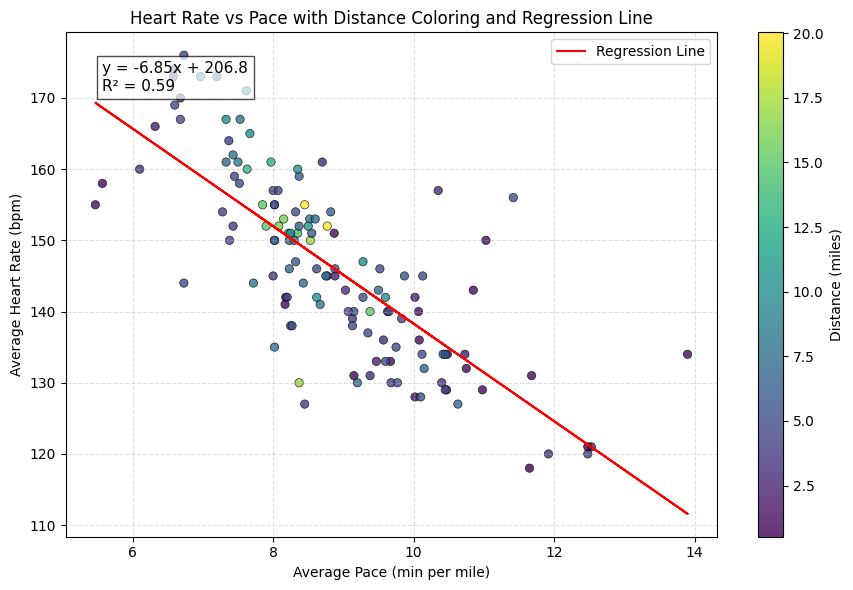

In [28]:
#Fit the regression line

z = np.polyfit(reg_data["Avg Pace"], reg_data["Avg HR"], 1)
p = np.poly1d(z)

#predict HR values using the regression
predicted_hr = p(reg_data["Avg Pace"])

#calculate r squared
ss_res = np.sum((reg_data["Avg HR"] - predicted_hr) ** 2)  # residual sum of squares
ss_tot = np.sum((reg_data["Avg HR"] - np.mean(reg_data["Avg HR"])) ** 2)  # total sum of squares
r2 = 1 - (ss_res / ss_tot)

#plot the scatter again
plt.figure(figsize=(9,6))
sc = plt.scatter(reg_data["Avg Pace"], reg_data["Avg HR"], c=reg_data["Distance"], cmap="viridis", alpha=0.8, edgecolors="black",linewidth=0.5)

#regression line
plt.plot(reg_data["Avg Pace"], p(reg_data["Avg Pace"]), color="red", label="Regression Line")

# Text annotation for slope, intercept, and R²
slope, intercept = z
plt.text(
    x=reg_data["Avg Pace"].min() + 0.1,
    y=reg_data["Avg HR"].max() - 5,
    s=f"y = {slope:.2f}x + {intercept:.1f}\nR² = {r2:.2f}",
    fontsize=11, color="black", bbox=dict(facecolor="white", alpha=0.7)
)

#Titles
plt.colorbar(sc, label="Distance (miles)")
plt.title("Heart Rate vs Pace with Distance Coloring and Regression Line")
plt.xlabel("Average Pace (min per mile)")
plt.ylabel("Average Heart Rate (bpm)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()
